# LSTM model for score prediction

In [1]:
import sys
import regex as re
import numpy as np
import io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import math
import tensorflow as tf
from numpy.linalg import norm
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, Lambda, TimeDistributed
from keras.layers import LSTM, Bidirectional, SimpleRNN, BatchNormalization, GRU, Masking
from keras.models import Model, load_model
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.activations import softmax
from keras.metrics import AUC
from keras.backend import clear_session
from copy import deepcopy
#from google.colab import drive
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

#drive.mount('/content/drive', force_remount=True)
#drive.mount('/content/drive')


#BASE_DIR = '/content/drive/My Drive/Colab Notebooks/thesis/'
BASE_DIR = '../'

# DATASET = "akribian"
DATASET = "assistments_2009"

# Training parameters
TIME_STEPS = 25
BATCH_SIZE = 128
EPOCHS = 4
PADDING = 0
EMBEDDINGS_DIM = 5
NUMBER_OF_FEATURES = 1
LSTM_UNITS = 400

# Cross validation
K = 5

# File paths 
INPUT_DIR = BASE_DIR + 'data/' + DATASET + '/processed/dkt/'

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load the data

In [3]:
with open(INPUT_DIR + 'inputs.npy', 'rb') as f:
    X = np.load(f)
with open(INPUT_DIR + 'outputs.npy', 'rb') as f:
    Y = np.load(f)
test_cutoff = math.floor(len(X) * 0.4)
test_length = math.floor(len(X) * 0.2)
X_test = X[test_cutoff : test_cutoff + test_length]
X_1 = X[:test_cutoff]
X_2 = X[test_cutoff + test_length:]
X = np.concatenate((X_1, X_2))
Y_test = Y[test_cutoff : test_cutoff + test_length]
Y_1 = Y[:test_cutoff]
Y_2 = Y[test_cutoff + test_length:]
Y = np.concatenate((Y_1, Y_2))

## Split into K-fold training & validation sets


In [4]:
kf = KFold(n_splits = K, shuffle = False)

## Train and average AUC across the k-fold splits


In [5]:
val_aucs = []
best_auc = 0
best_model = None
clear_session()
auc = AUC()
for train_index, val_index in kf.split(X):
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_val = X[val_index]
    Y_val = Y[val_index]
    model = Sequential()
    model.add(Embedding())
    model.add(Masking(mask_value=0, input_shape=(TIME_STEPS, EMBEDDINGS_DIM * 2 + NUMBER_OF_FEATURES)))
    #model.add(SimpleRNN(LSTM_UNITS))
    model.add(LSTM(LSTM_UNITS))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=[auc])
    history = model.fit(X_train, Y_train, 
                        validation_data = (X_val, Y_val), 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE)
    val_auc = history.history['val_auc'][-1]
    val_aucs.append(val_auc)
    if val_auc > best_auc:
      best_auc = val_auc
      best_model = model
    break

Epoch 1/4
1046/1046 [==============================] - 169s 157ms/step - loss: 0.6122 - auc: 0.6529 - val_loss: 0.5610 - val_auc: 0.6620
Epoch 2/4
1046/1046 [==============================] - 174s 166ms/step - loss: 0.5736 - auc: 0.7111 - val_loss: 0.5546 - val_auc: 0.6726
Epoch 3/4
1046/1046 [==============================] - 171s 163ms/step - loss: 0.5641 - auc: 0.7258 - val_loss: 0.5565 - val_auc: 0.6741
Epoch 4/4
1046/1046 [==============================] - 155s 148ms/step - loss: 0.5569 - auc: 0.7345 - val_loss: 0.5611 - val_auc: 0.6743


In [6]:
# Save model 
model = best_model
model.save(BASE_DIR + "model-" + DATASET)

INFO:tensorflow:Assets written to: ../model-assistments_2009\assets
INFO:tensorflow:Assets written to: ../model-assistments_2009\assets


In [7]:
print("Mean validation AUC: %f" % np.mean(val_aucs))

Mean validation AUC: 0.674261


## Plot ROC and AUC graphs

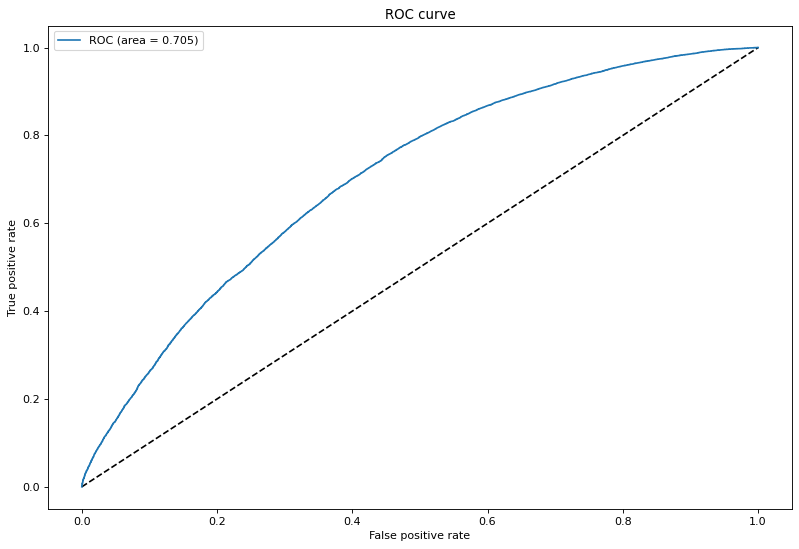

In [8]:
Y_pred = model.predict(X_test)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, Y_pred)
auc_keras = roc_auc_score(Y_test, Y_pred)
#auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1, figsize=(12,8), dpi=80)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ROC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# # Zoom in view of the upper left corner.
# plt.figure(2, figsize=(12,8), dpi=100)
# plt.xlim(0, 0.4)
# plt.ylim(0.6, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='ROC (area = {:.3f})'.format(auc_keras))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

691

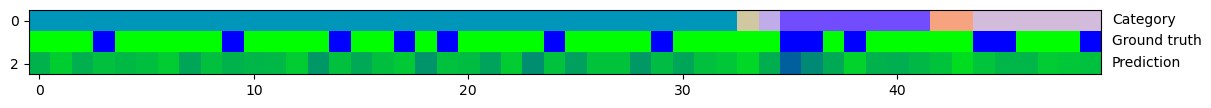

In [9]:
start = np.random.choice(len(X_test))
#start = 700
length = 50
sample_indices = range(start, start + length)

img = np.zeros((3,length,3))

X_samples = X_test[sample_indices, TIME_STEPS - 1, EMBEDDINGS_DIM:EMBEDDINGS_DIM+3]
X_samples -= np.min(X_samples)
X_samples /= np.max(X_samples)

img[0,:,:] = X_samples

Y_truth = Y_test[sample_indices]
img[1,:,1] = Y_truth
img[1,:,2] = 1. - Y_truth

Y_prediction = Y_pred[sample_indices]
img[2,:,1] = Y_prediction[:,0]
img[2,:,2] = 1. - Y_prediction[:,0]

fig3 = plt.figure(3, figsize=(12,8), dpi=100, constrained_layout=True)

image = plt.imshow(img)

plt.text(length, 0.15, "Category")
plt.text(length, 1.15, "Ground truth")
plt.text(length, 2.15, "Prediction")

start